In [1]:
import numpy as np
from pycbf import CPUCoherenceBeamformer
from pycbf import CPUBeamformer
import matplotlib.pyplot as plt
import timuscle.beamforming as tibf
import timuscle.dataio as dio
from scipy.signal import hilbert, coherence
import os

In [2]:
from timuscle.autoprocessing.__rf_preproc__ import __GE9LD_SORT__ as reorg

In [3]:
reorg

array([119, 120, 115, 121, 114, 122, 113, 123, 112, 124, 118, 125, 117,
       126, 116, 127, 180, 191, 181, 190, 182, 189, 183, 188, 164, 187,
       165, 186, 166, 185, 171, 184,  32,  43,  33,  42,  34,  41,  35,
        40,  36,  47,  37,  46,  38,  45,  39,  44, 240, 244, 241, 245,
       242, 246, 243, 247, 227, 228, 226, 229, 225, 230, 224, 231,  48,
        56,  50,  57,  52,  58,  54,  60,  49,  62,  51,  59,  53,  61,
        55,  63, 235, 239, 234, 238, 233, 237, 232, 236, 251, 255, 250,
       254, 249, 253, 248, 252,   7,  11,   6,  10,   5,   9,   4,   8,
         3,  15,   2,  14,   1,  13,   0,  12, 204, 196, 205, 197, 192,
       198, 193, 199, 194, 208, 195, 209, 206, 210, 207, 211,  16,  27,
        17,  26,  18,  25,  19,  24,  20,  31,  21,  30,  22,  29,  23,
        28, 215, 223, 214, 222, 213, 221, 212, 220, 203, 216, 202, 217,
       201, 218, 200, 219,  82,  83,  81,  84,  80,  85,  79,  86,  67,
        68,  66,  69,  65,  70,  64,  71, 144, 151, 145, 150, 14

In [81]:
path = "/home/wew12/data/invivo/RawData/"
path = "/fastrs/ultrasound/TIMuscle/InVivo/20230512_P003_v2/acq_06_flex_42_pushfocus_25mm/RawData"
path = "/fastrs/ultrasound/TIMuscle/InVivo/20230519_P006/acq_05_kf_43_vl_L/RawData"
path = "/fastrs/ultrasound/TIMuscle/InVivo/20230421_V001/acq_2_flex_45_musc_vl/RawData"
path = "/fastrs/ultrasound/TIMuscle/ExVivo/20250423_exvivo_porkchop/exvivo_warm/SSI_radius_1.00/acq_001/RawData"
path = "/fastrs/ultrasound/TIMuscle/ExVivo/20250423_exvivo_porkchop/exvivo_warm/SSI_radius_1.00/acq_002/RawData"

rf, dims, params = dio.verasonics_loadbmoderf(path)

allfiles = os.listdir(path)
allfiles.sort()

# find the tracking RF data
fname = allfiles[-2][:-4]

print(rf.shape)

if params['trans']['Trans']['name'] == "GE9LD":
    loadpath = os.path.join(path, fname+".bin")
    rfraw = np.memmap(loadpath, dtype=np.int16).reshape(256, -1)[reorg,:int(np.prod(rf.shape[1:]))]
    rf = rfraw.reshape(rf.shape)

t = dims['t_sec']

c = params['c']
f = params['f']
lam = c/f

na = int(params['track_params']['rf']['na'])
dtheta = params['track_params']['rf']['dtheta']

steers = dtheta * (np.arange(na) - (na-1)/2)

nele = int(params['trans']['nele'])
dele = params['trans']['dele']
xele = dele * (np.arange(nele) - (nele-1)/2)

fnum = 0.8

xout, zout = tibf.make_recon_grid_by_BW_2D(
    fnum = fnum,
    lam = lam,
    xmin = -18E-3,
    xmax = 18E-3,
    zmin = 15E-3,
    zmax = 25E-3
)

tautx, taurx, apodtx, apodrx = tibf.make_tabs_and_apods_pw_2D(
    steers=steers,
    ctx=c,
    cm=1470,
    xele=xele,
    xout=xout,
    zout=zout,
    fnum=1
)

(192, 1, 11, 1664)


In [6]:
bmfrm = CPUCoherenceBeamformer(
    tautx=tautx,
    taurx=taurx,
    apodtx=apodtx,
    apodrx=apodrx,
    t0 = t[0],
    dt = t[1]-t[0],
    nt = len(t),
    nwrkr=1
)

In [7]:
im = bmfrm(rf[:,0,:,:].transpose(1, 0, 2)).reshape(-1,len(xout), len(zout))

In [5]:
def calc_coherence(subset):
    # subtract the mean of each aline
    submmu = subset - np.mean(subset, axis=0, keepdims=True)
    sig = np.std(subset, axis=0)
    n = len(sig)

    # caculate the lag-n coherence
    rhos = np.zeros(len(sig)-1)
    for lag in range(subset.shape[1]-1):
        cross = np.mean(submmu[:,:n-lag] * submmu[:,lag:], axis=0)
        rhos[lag] = np.mean(cross / (sig[:n-lag] * sig[lag:]))
    
    return rhos

def calc_lagn_coherence(subset, lag:int):
    submmu = subset - np.mean(subset, axis=0, keepdims=True)
    sig = np.std(subset, axis=0)
    n = len(sig)

    cross = np.mean(submmu[:,:n-lag] * submmu[:,lag:], axis=0)
    return np.mean(cross / (sig[:n-lag] * sig[lag:]))

In [6]:
apodrx_coherence = apodrx.reshape(-1, len(xout), len(zout))

In [7]:
from tqdm.notebook import tqdm

In [68]:
dz = zout[1]-zout[0]
nkern = int(np.ceil(0.5 * lam / (dz)/2))
dsfx = 2
dsfz = 2*dsfx
soses = np.arange(1450, 1651, 5)

loc = np.zeros((len(soses), 1+xout.size//dsfx, 1+zout.size//dsfz))
ims = np.zeros((len(soses), xout.size, zout.size))

for isos, sos in tqdm(enumerate(soses), total=len(soses)):
    tautx, taurx, apodtx, apodrx = tibf.make_tabs_and_apods_pw_2D(
        steers=steers,
        ctx=c,
        cm=sos,
        xele=xele,
        xout=xout,
        zout=zout,
        fnum=1
    )

    apodrx_coherence = apodrx.reshape(-1, len(xout), len(zout))

    bmfrm = CPUCoherenceBeamformer(
        tautx=tautx,
        taurx=taurx,
        apodtx=apodtx,
        apodrx=apodrx,
        t0 = t[0],
        dt = t[1]-t[0],
        nt = len(t),
        nwrkr=1
    )

    im = bmfrm(rf[:,0,:,:].transpose(1, 0, 2)).reshape(-1,len(xout), len(zout))
    
    ims[isos] = np.sum(im, axis=0)
    del bmfrm

    for ix in tqdm(range(0, xout.size, dsfx), leave=False):
        for iz in range(0, zout.size, dsfz):
            izmin = np.max([0, iz-nkern])
            izmax = np.min([zout.size, iz+nkern+1])

            mask = apodrx_coherence[:,ix,izmin:izmax]
            elesel = np.sum(mask, axis=-1) == mask.shape[-1]

            if np.sum(elesel) < 2: continue

            channels = im[elesel,ix,izmin:izmax]

            loc[isos, ix//dsfx,iz//dsfz] = calc_lagn_coherence(channels.T, 1)
    
    
            
    # ex_axlat = 1E3*np.array([xout[0], xout[-1], zout[-1], zout[0]])

    # fig, axes = plt.subplots(1, 2)
    # fig.set_size_inches(10, 4)
    # ax = axes[1]
    # pltim = ax.imshow(loc[isos].T, cmap='GnBu_r', extent=ex_axlat, vmin=-0.0, vmax=1)
    # ax.set_ylabel("Axial [mm]")
    # ax.set_xlabel("Lateral [mm]")
    # ax.set_title("Lag One Coherence")
    # plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("LOC")

    

    # env = np.abs(hilbert(rf[isos], axis=-1)).T
    # logged = 20 * np.log10(env/np.percentile(env, 99))

    # ax = axes[0]
    # pltim = ax.imshow(logged, vmin=-35, vmax=5, cmap='gray', extent=ex_axlat)
    # ax.set_ylabel("Axial [mm]")
    # ax.set_xlabel("Lateral [mm]")
    # ax.set_title("Delay-And-Sum B-mode")
    # plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("dB")
    # fig.suptitle(f"SOS = {sos:0.00f} m/s")
    # plt.show()

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

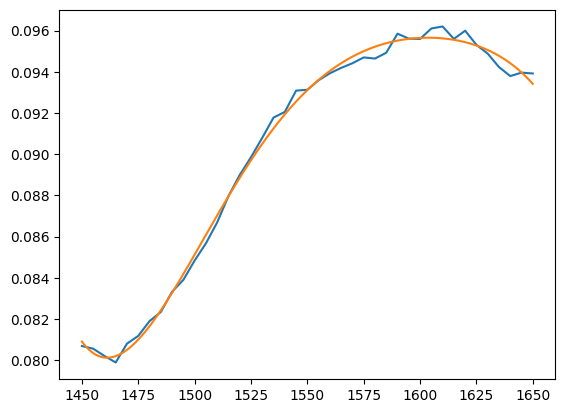

In [74]:
locmu = np.mean(loc, axis=(1,2))

sosfine = np.linspace(soses[0], soses[-1], 1001)
deg = 5
pows = sosfine[None,:] ** (deg - np.arange(deg+1))[:,None]
coefs = np.polyfit(soses, locmu, deg)[:,None]

fit = np.sum(pows * coefs, axis=0)
plt.figure()
plt.plot(soses, locmu)
plt.plot(sosfine, fit)
plt.show()

sospeak = sosfine[np.argmax(fit)]

In [70]:
deg - np.arange(deg+1)

coefs

array([[-5.65209145e-13],
       [ 4.44646271e-09],
       [-1.39875437e-05],
       [ 2.19927439e-02],
       [-1.72825114e+01],
       [ 5.42997792e+03]])

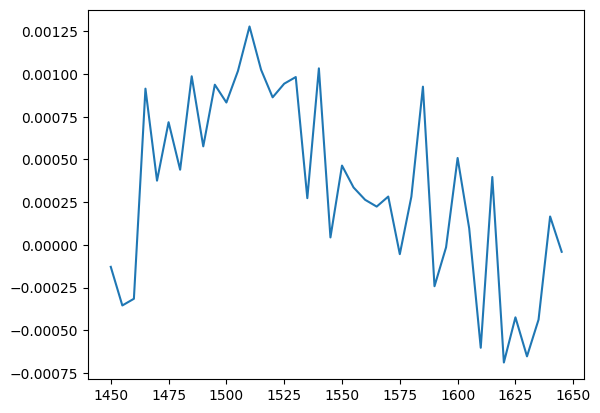

In [71]:
locmu = np.mean(np.diff(loc,axis=0), axis=(1,2))
plt.figure()
plt.plot(soses[:-1], locmu)
plt.show()

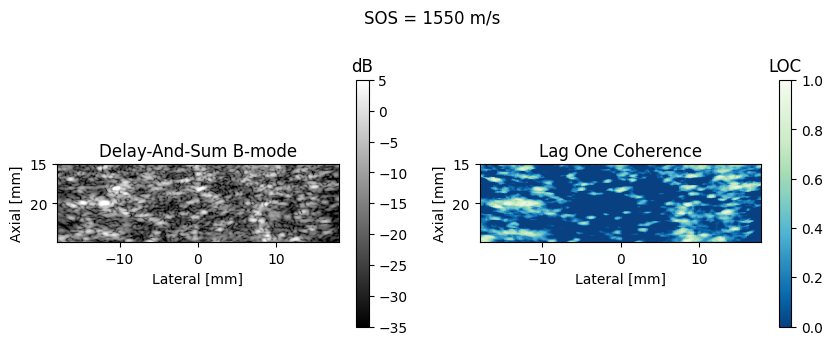

In [75]:
np.argmax(locmu)

for isos in [20]:
    ex_axlat = 1E3*np.array([xout[0], xout[-1], zout[-1], zout[0]])

    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(10, 4)
    ax = axes[1]
    pltim = ax.imshow(loc[isos].T, cmap='GnBu_r', extent=ex_axlat, vmin=-0.0, vmax=1)
    ax.set_ylabel("Axial [mm]")
    ax.set_xlabel("Lateral [mm]")
    ax.set_title("Lag One Coherence")
    plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("LOC")

    

    env = np.abs(hilbert(ims[isos], axis=-1)).T
    logged = 20 * np.log10(env/np.percentile(env, 99))

    ax = axes[0]
    pltim = ax.imshow(logged, vmin=-35, vmax=5, cmap='gray', extent=ex_axlat)
    ax.set_ylabel("Axial [mm]")
    ax.set_xlabel("Lateral [mm]")
    ax.set_title("Delay-And-Sum B-mode")
    plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("dB")
    fig.suptitle(f"SOS = {soses[isos]:0.00f} m/s")
    plt.show()

In [88]:
sospeak = 1660

  0%|          | 0/170 [00:00<?, ?it/s]

/tmp/ipykernel_150141/2663387294.py:21: RuntimeWarning: invalid value encountered in divide
  return np.mean(cross / (sig[:n-lag] * sig[lag:]))


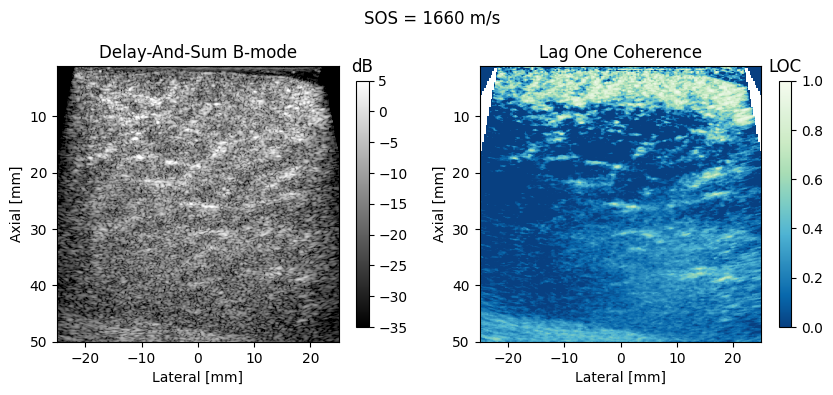

In [89]:
xout, zout = tibf.make_recon_grid_by_BW_2D(
    fnum = 1,
    lam = lam,
    xmin = -25E-3,
    xmax = 25E-3,
    zmin = 1E-3,
    zmax = 50E-3
)

tautx, taurx, apodtx, apodrx = tibf.make_tabs_and_apods_pw_2D(
    steers=steers,
    ctx=c,
    cm=sospeak,
    xele=xele,
    xout=xout,
    zout=zout,
    fnum=1
)

apodrx_coherence = apodrx.reshape(-1, len(xout), len(zout))

bmfrm = CPUCoherenceBeamformer(
    tautx=tautx,
    taurx=taurx,
    apodtx=apodtx,
    apodrx=apodrx,
    t0 = t[0],
    dt = t[1]-t[0],
    nt = len(t),
    nwrkr=1
)

im = bmfrm(rf[:,0,:,:].transpose(1, 0, 2)).reshape(-1,len(xout), len(zout))

locpeak = np.zeros((1+xout.size//dsfx, 1+zout.size//dsfz))
for ix in tqdm(range(0, xout.size, dsfx), leave=False):
    for iz in range(0, zout.size, dsfz):
        izmin = np.max([0, iz-nkern])
        izmax = np.min([zout.size, iz+nkern+1])

        mask = apodrx_coherence[:,ix,izmin:izmax]
        elesel = np.sum(mask, axis=-1) == mask.shape[-1]

        if np.sum(elesel) < 2: continue

        channels = im[elesel,ix,izmin:izmax]

        locpeak[ix//dsfx,iz//dsfz] = calc_lagn_coherence(channels.T, 1)

ex_axlat = 1E3*np.array([xout[0], xout[-1], zout[-1], zout[0]])

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
ax = axes[1]
pltim = ax.imshow(locpeak.T, cmap='GnBu_r', extent=ex_axlat, vmin=-0.0, vmax=1)
ax.set_ylabel("Axial [mm]")
ax.set_xlabel("Lateral [mm]")
ax.set_title("Lag One Coherence")
plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("LOC")



env = np.abs(hilbert(np.sum(im, axis=0), axis=-1)).T
logged = 20 * np.log10(env/np.percentile(env, 99))

ax = axes[0]
pltim = ax.imshow(logged, vmin=-35, vmax=5, cmap='gray', extent=ex_axlat)
ax.set_ylabel("Axial [mm]")
ax.set_xlabel("Lateral [mm]")
ax.set_title("Delay-And-Sum B-mode")
plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("dB")
fig.suptitle(f"SOS = {sospeak:0.00f} m/s")
plt.show()

  0%|          | 0/128 [00:00<?, ?it/s]

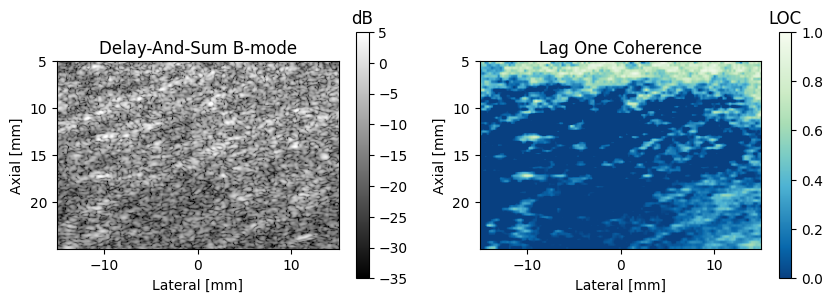

In [11]:
dz = zout[1]-zout[0]
nkern = int(np.ceil(0.5 * lam / (dz)/2))
dsfx = 2
dsfz = 4*dsfx

loc = np.zeros((1+xout.size//dsfx, 1+zout.size//dsfz))
for ix in tqdm(range(0, xout.size, dsfx)):
    for iz in range(0, zout.size, dsfz):
        izmin = np.max([0, iz-nkern])
        izmax = np.min([zout.size, iz+nkern+1])

        mask = apodrx_coherence[:,ix,izmin:izmax]
        elesel = np.sum(mask, axis=-1) == mask.shape[-1]

        if np.sum(elesel) < 2: continue

        channels = im[elesel,ix,izmin:izmax]

        loc[ix//dsfx,iz//dsfz] = calc_lagn_coherence(channels.T, 1)

ex_axlat = 1E3*np.array([xout[0], xout[-1], zout[-1], zout[0]])

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
ax = axes[1]
pltim = ax.imshow(loc.T, cmap='GnBu_r', extent=ex_axlat, vmin=-0.0, vmax=1)
ax.set_ylabel("Axial [mm]")
ax.set_xlabel("Lateral [mm]")
ax.set_title("Lag One Coherence")
plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("LOC")

env = np.abs(hilbert(np.sum(im, axis=0), axis=-1)).T
logged = 20 * np.log10(env/np.percentile(env, 99))

ax = axes[0]
pltim = ax.imshow(logged, vmin=-35, vmax=5, cmap='gray', extent=ex_axlat)
ax.set_ylabel("Axial [mm]")
ax.set_xlabel("Lateral [mm]")
ax.set_title("Delay-And-Sum B-mode")
plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("dB")
plt.show()

In [70]:
dz = zout[1]-zout[0]
nlam  = 0.5
nhalf = int(np.ceil(nlam * lam / (dz)/2))

im.shape, apodrx_coherence.shape

istart = int(0)
cohers = []
for lag in range(1,1+1):
    nkern  = 1 + 2*nhalf
    nstck  = int((im.shape[-1]-istart)//nkern)
    axsel  = slice(istart, istart + nstck*nkern)

    shape  = (apodrx_coherence.shape[0], apodrx_coherence.shape[1], nstck, nkern)
    mask   = apodrx_coherence[:,:,axsel].reshape(shape)
    subset = im[:,:,axsel].reshape(shape)
    subset = subset - np.mean(subset, axis=-1, keepdims=True)

    has_nkern = np.sum(mask, axis=-1) == nkern

    sig0  = np.std(subset[:-lag], axis=-1)
    sig1  = np.std(subset[lag :], axis=-1)
    cross = np.mean(subset[:-lag] * subset[lag :], axis=-1)
    valid = has_nkern[:-lag] & has_nkern[lag :] 
    valid &= np.sum(valid, axis=0, keepdims=True) >=8

    rhos = cross / (sig0 * sig1)
    rhos[~valid] = np.nan
    coher = np.nanmean(rhos, axis=0)
    cohers.append(coher)

cohers=np.array(cohers)

/tmp/ipykernel_126280/3812326528.py:27: RuntimeWarning: invalid value encountered in divide
  rhos = cross / (sig0 * sig1)
/tmp/ipykernel_126280/3812326528.py:29: RuntimeWarning: Mean of empty slice
  coher = np.nanmean(rhos, axis=0)


/tmp/ipykernel_75019/209383329.py:10: RuntimeWarning: Mean of empty slice
  slsc = np.nanmean(cohers[:10], axis=0)


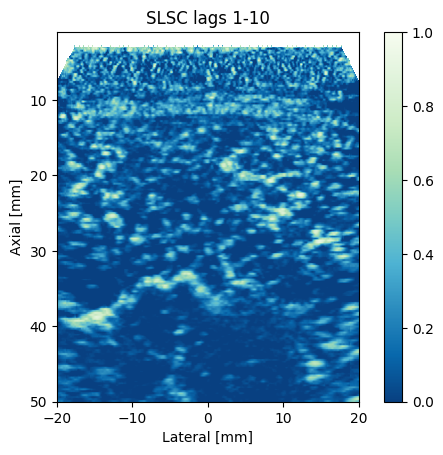

In [10]:
# for icoher, coher in enumerate(cohers):
#     plt.figure()
#     plt.imshow(coher.T, extent=ex_axlat, cmap='GnBu_r', vmin=0, vmax=1)
#     plt.title(f"Lag {icoher+1} Coherence")
#     plt.colorbar()
#     plt.xlabel("Lateral [mm]")
#     plt.ylabel("Axial [mm]")
#     plt.show()

slsc = np.nanmean(cohers[:10], axis=0)

plt.figure()
plt.imshow(slsc.T, extent=ex_axlat, cmap='GnBu_r', vmin=0, vmax=1)
plt.colorbar()
plt.xlabel("Lateral [mm]")
plt.ylabel("Axial [mm]")
plt.title("SLSC lags 1-10")
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


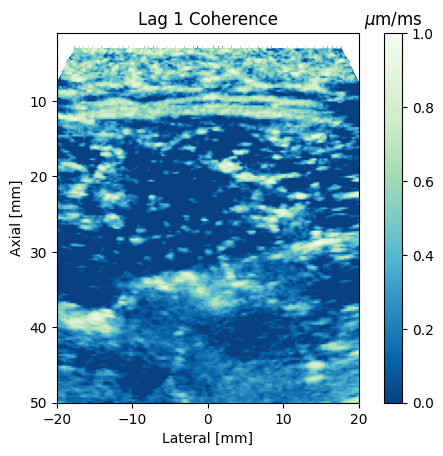

In [85]:
from matplotlib.animation import FuncAnimation

ilagsel = 0
fig, ax = plt.subplots(1,1)
axim = ax.imshow(cohers[ilagsel].T, vmin=0, vmax=1, extent=ex_axlat, cmap='GnBu_r')
plt.colorbar(axim, ax=ax).ax.set_title("$\\mu$m/ms")
ax.set_title(f"Lag {ilagsel+1} Coherence")
ax.set_xlabel("Lateral [mm]")
ax.set_ylabel("Axial [mm]")

def plotit(ilagsel, ax):
    ax.clear()
    ax.imshow(cohers[ilagsel].T, vmin=0, vmax=1, extent=ex_axlat, cmap='GnBu_r')
    ax.set_title(f"Lag {ilagsel+1} Coherence")
    ax.set_xlabel("Lateral [mm]")
    ax.set_ylabel("Axial [mm]")

    return ax,

ani = FuncAnimation(fig, plotit, np.arange(cohers.shape[0]-1, dtype=int), fargs=(ax,))

ani.save(
    f"slsc.gif",
    fps=2
)

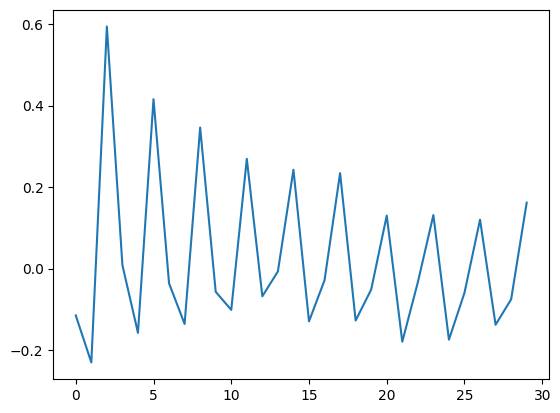

In [86]:
plt.figure()
plt.plot(cohers[:,cohers.shape[1]//2,cohers.shape[2]//2])
plt.show()